# Stock Valuation

This project aims to try and determine whether a stock price is fairly valued, undervalued or overvalued by making use of a variety of metrics. At present this is still a work in progress.

## Company Information

This code is a template for use later on when more company information is required to assess the value of a stock.

In [ ]:
import yfinance as yf

# Example stock symbol
stock_symbol = 'AAPL'

# Create a Ticker object
ticker = yf.Ticker(stock_symbol)

# Get stock information
info = ticker.info

# Access specific metrics
pe_ratio = info.get('trailingPE', None)  # P/E ratio
forward_pe = info.get('forwardPE', None)  # Forward P/E ratio
peg_ratio = info.get('pegRatio', None)  # PEG ratio
price_to_book = info.get('priceToBook', None)  # Price/Book ratio
enterprise_to_revenue = info.get('enterpriseToRevenue', None)  # Enterprise Value/Revenue
enterprise_to_ebitda = info.get('enterpriseToEbitda', None)  # Enterprise Value/EBITDA

# Cash flow data is not directly available through the `info` attribute. 
# You need to use `cashflow` for the cash flow statement:
cash_flow_statement = ticker.cashflow

# Print the metrics
print(f"Stock: {stock_symbol}")
print(f"P/E Ratio: {pe_ratio}")
print(f"Forward P/E Ratio: {forward_pe}")
print(f"PEG Ratio: {peg_ratio}")
print(f"Price to Book Ratio: {price_to_book}")
print(f"Enterprise to Revenue: {enterprise_to_revenue}")
print(f"Enterprise to EBITDA: {enterprise_to_ebitda}")
print("\nCash Flow Statement (Annual):")
print(cash_flow_statement)

# Note: The cash flow statement provided here is annual by default. 
# You can get quarterly data by passing `quarterly=True` to `cashflow`.

***

# Value Analysis

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np

url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
sp500_df = pd.read_html(url, header=0)[0] # S&P500 dataset

In [11]:
def fetch_metrics(tickers):
    """Fetches financial metrics for a list of tickers."""
    metrics = {'PE_Ratio': [], 'PB_Ratio': [], 'PEG_Ratio': [], 'Dividend_Yield': []}
    for ticker in tickers:
        info = yf.Ticker(ticker).info
        metrics['PE_Ratio'].append(info.get('trailingPE', np.nan))
        metrics['PB_Ratio'].append(info.get('priceToBook', np.nan))
        metrics['PEG_Ratio'].append(info.get('pegRatio', np.nan))
        metrics['Dividend_Yield'].append(info.get('dividendYield', np.nan) if info.get('dividendYield') is not None else np.nan)
    return pd.DataFrame(metrics)

def calculate_benchmarks(df):
    """Calculates benchmarks (median) for a DataFrame of financial metrics."""
    return df.median().to_dict()

def compare_stock_to_benchmarks(stock_metrics, sp500_benchmarks, sector_benchmarks):
    """Compares a single stock's metrics to S&P 500 and sector benchmarks."""
    comparison = {}
    for metric in stock_metrics.index:
        comparison[metric] = {
            'Stock': stock_metrics[metric],
            'S&P 500 Median': sp500_benchmarks.get(metric, np.nan),
            'Sector Median': sector_benchmarks.get(metric, np.nan),
        }
    return comparison

# Fetch S&P 500 data
sp500_symbols = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].tolist()

# Fetch Technology sector data
it_sector_df = sp500_df[sp500_df['GICS Sector'] == 'Information Technology']
it_symbols = it_sector_df['Symbol'].tolist()


# Calculate benchmarks
sp500_data = fetch_metrics(sp500_symbols)
it_data = fetch_metrics(it_symbols)

sp500_benchmarks = calculate_benchmarks(sp500_data)
it_benchmarks = calculate_benchmarks(it_data)

# Fetch individual stock metrics and compare
aapl_metrics = fetch_metrics(['AAPL']).iloc[0]
comparison = compare_stock_to_benchmarks(aapl_metrics, sp500_benchmarks, it_benchmarks)

# Printing results
for metric, values in comparison.items():
    print(f"{metric}: Stock = {values['Stock']:.2f}, S&P 500 Median = {values['S&P 500 Median']:.2f}, Sector Median = {values['Sector Median']:.2f}")

PE_Ratio: Stock = 26.20, S&P 500 Median = 25.55, Sector Median = 37.42
PB_Ratio: Stock = 35.15, S&P 500 Median = 3.50, Sector Median = 7.05
PEG_Ratio: Stock = 2.76, S&P 500 Median = 1.96, Sector Median = 2.48
Dividend_Yield: Stock = 0.01, S&P 500 Median = 0.02, Sector Median = 0.02


In [12]:
def valuation_status(value, metric, sector_benchmarks):
    # Example thresholds based on sector medians; adjust these as needed
    if metric in sector_benchmarks:
        median = sector_benchmarks[metric]
        if value < median * 0.8:
            return 'Undervalued'
        elif value > median * 1.2:
            return 'Overvalued'
        else:
            return 'Fair Value'
    return 'N/A'

In [13]:
# Assuming 'it_data' is already fetched and 'it_benchmarks' is calculated
results = []
for symbol in it_symbols:
    metrics = fetch_metrics([symbol]).iloc[0]
    status = {metric: valuation_status(metrics[metric], metric, it_benchmarks) for metric in metrics.index}
    row = {'Ticker': symbol, **metrics.to_dict(), **{f'{metric} Status': val for metric, val in status.items()}}
    results.append(row)

df = pd.DataFrame(results)

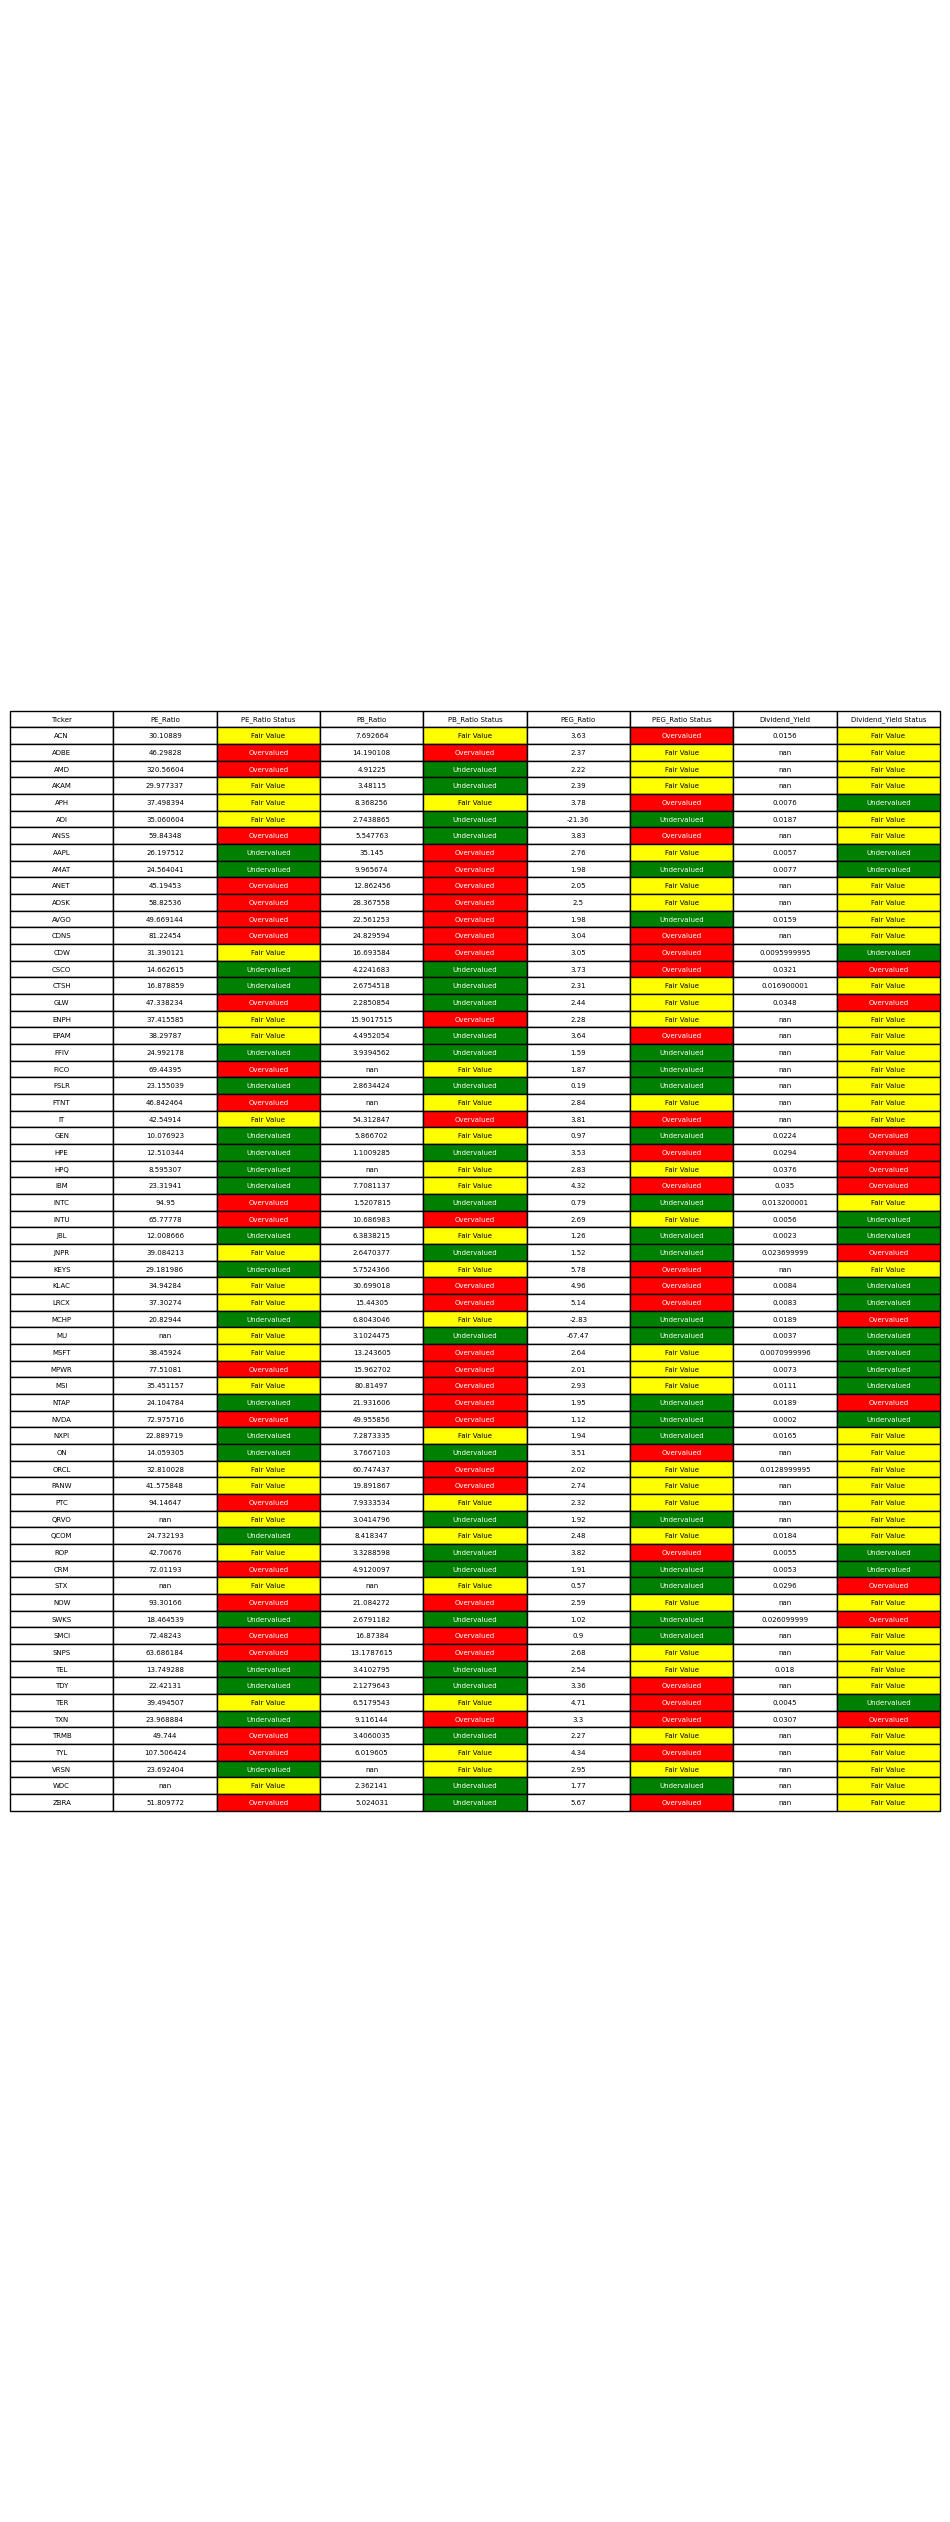

In [14]:
def plot_table_colored(df):
    fig, ax = plt.subplots(figsize=(12, len(df) * 0.5))  # Adjust size as needed
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

    # Apply coloring based on valuation status
    for (i, j), cell in the_table.get_celld().items():
        if j >= 1:  # Skip the index column
            value = cell.get_text().get_text()
            if "Undervalued" in value:
                cell.set_facecolor('green')
                cell.get_text().set_color('white')
            elif "Overvalued" in value:
                cell.set_facecolor('red')
                cell.get_text().set_color('white')
            elif "Fair Value" in value:
                cell.set_facecolor('yellow')
                cell.get_text().set_color('black')
    
    plt.show()

# Example DataFrame columns: ['Ticker', 'PE_Ratio', 'PE_Ratio Status', ...]
plot_table_colored(df[['Ticker', 'PE_Ratio', 'PE_Ratio Status', 'PB_Ratio', 'PB_Ratio Status', 'PEG_Ratio', 'PEG_Ratio Status', 'Dividend_Yield', 'Dividend_Yield Status']])